<a href="https://colab.research.google.com/github/Murcha1990/ML_Course_PT/blob/main/Lecture4_Clustering%26MLSD/PT_boostings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Градиентный бустинг

#### Catboost vs. LightGBM vs. XGBoost

*  Сравнение моделей на искусственном примере
*  CatBoost для решения задачи
*  Интерпретация модели
*  Блендинг и стекинг

В прошлый раз мы посмотрели простую версию градиентного бустинга из scikit-learn, [придуманную в 1999 году Фридманом](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451). Прогресс не стоит на месте, и на сегодняшний день есть три популярные библиотеки с разными имплементациями градиентного бустинга, которые на практике показывают лушие результаты:
*  **XGBoost**. Появилась в 2014 году, [статья автора](https://mran.microsoft.com/snapshot/2020-07-15/web/packages/xgboost/vignettes/xgboost.pdf) вышла в 2016. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Об особенностях данной библиотеки рассказывалось на лекции.
* **CatBoost** от компании Яндекс с релизом в 2017 году. Алгоритм можно запускать с дефолтными гиперпараметрами, потому тчо он является менее чувствительным к выбору их конкретных значений. Отлично умеет работать с категориальным признаками, при этом автоматически обрабатывая полученные на вход непредобработанные фичи.
* **LightGBM**. Релиз в один год с Catboost, библиотека от Microsoft. Отличается очень быстрым построением композиции. Например, при построении узла дерева, вместо перебора по всем значениям признака, производится перебор значений гистограммы этого признака. Таким образом, вместо $O(N)$ требуется $O$(m), где $m$ - число бинов гистограммы. В отличие от других библиотек, строит деревья в глубину, при этом на каждом шаге строит вершину, дающую наибольшее уменьшение функционала.



|Критерий|Catboost|Lightgbm|Xgboost|
|--|--|--|--|
|Год релиза|2014|2017|2017|
|Построение деревьев|симметрично по уровням|в глубину|асимметрично по уровням до максимальной глубины с прунингом|
|Параметры контроля переобучения|learning_rate, depth, l2-leaf-reg (аналога min_child_weigth нет) |learning_rate, max_depth, num_leaves, min_data_in_leaf|learning_rate (eta), min_child_weigth, max_depth|
|Контроль скорости обучения|rsm, iterations|feature_fraction, bagging_fraction, num_iterations|n_estimator, colsample_bytree, subsample|
|Параметры категориальных фичей|cat_features, one_hot_max_size|categorical_feature|не доступно|
|Бинаризация признаков|сетка выбирается заранее|-|перебор всех границ, выбор сетки на каждой итерации|
|Скор сплита|Похожесть векторов градиентов |-| Смотрим на изменение функции ошибки|
|Bootstrap|Можно перевзвешивать и менять интенсивность |-|-|
|Рандомизация скора сплита|+ |-|-|


### Основные параметры

* objective – функция ошибки для настройки композиция
* learning_rate / eta – скорость обучения
* n_estimators / num_iterations – число итераций градиентного бустинга

### Настройка сложности деревьев

* max_depth – максимальная глубина
* max_leaves / num_leaves – максимальное число вершин в дереве
* gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
* min_data_in_leaf – минимальное число объектов в листе
* min_sum_hessian_in_leaf – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление
* lambda – коэффициент регуляризации (L2)
* subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева
* colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева

Начать настройку можно с самых главных параметров: learning_rate и n_estimators. Один из них фиксируем, оставшийся из этих двух параметров подбираем (например, подбираем скорость обучения при n_estimators=100). Следующий параметр по важности - max_depth, так как мы хотим неглубокие деревья (в Catboost и LightGBM) для снижения переобучения.



**Техническое отступление**

Данные библиотеки необходимо сначала устанавливать (можно через pip / conda или brew, если Вы работаете на MAC OS).
Чтобы у Вас точно вопроизводился ноутбук и не было проблем из-за несовпадающих версий библиотек, рекомендуется через python создавать виртуальную среду. Подробнее см. файлики ```техническое_отступление.md``` и ```requirements.txt```.

В текущем ноутбуке использовались следующие версии библиотек:

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

!pip install catboost lightgbm xgboost

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 52.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which i

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [1]:
import warnings
warnings.filterwarnings('ignore')

import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost

plt.rcParams["figure.figsize"] = (8, 5)

## Catboost и другие бустинги для искусственного примера

В алгоритме сделаны улучшения и выбор разных опций для борьбы с переобучением, подсчету сркднего таргета на отложенной выборке, подсчету статистик по категориальным фичам, бинаризацией фичей, рандомизации скора сплита, разные типы бутсрапирования.

Давайте сначала зафиксируем все гиперпараметры со значениями по умолчанию, кроме количества деревьев в композиции - `n_estimators`.

In [2]:
def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график сами наблюдения
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

0.919452347083926


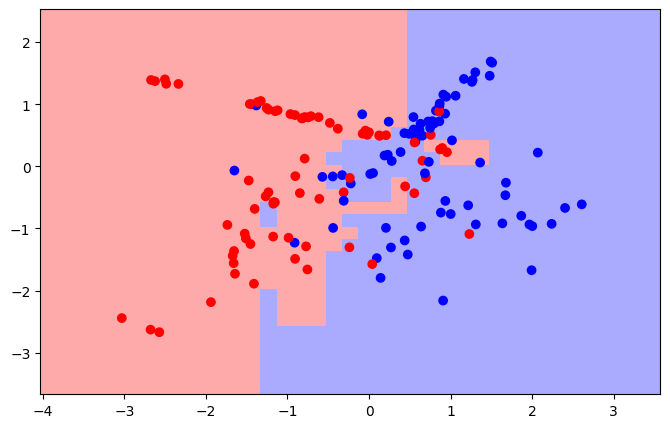

In [3]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(n_estimators=300, logging_level='Silent')
catboost.fit(X_train, y_train)
plot_surface(X_test, y_test, catboost)

print(roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1]))

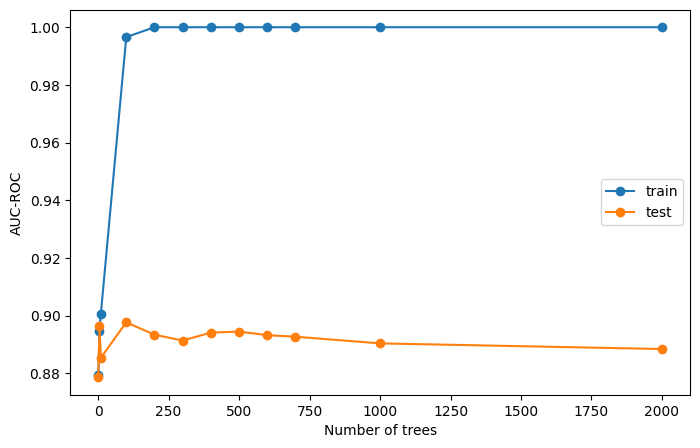

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000]
quals_train = []
quals_test = []
for n in n_trees:
    boost = GradientBoostingClassifier(n_estimators=n)
    boost.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, boost.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, boost.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

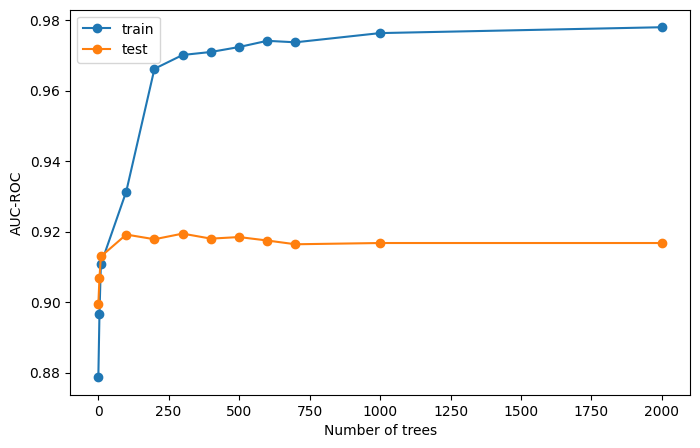

In [5]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000]
quals_train = []
quals_test = []
for n in n_trees:
    catboost = CatBoostClassifier(iterations=n, logging_level='Silent')
    catboost.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

## Xgboost

1. Базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

2. Функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

3. При построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

4. Критерий останова при обучении дерева также зависит от оптимального сдвига

Ссылка на [источник](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/lecture-notes/lecture11-ensembles.pdf)

0.8797119487908962


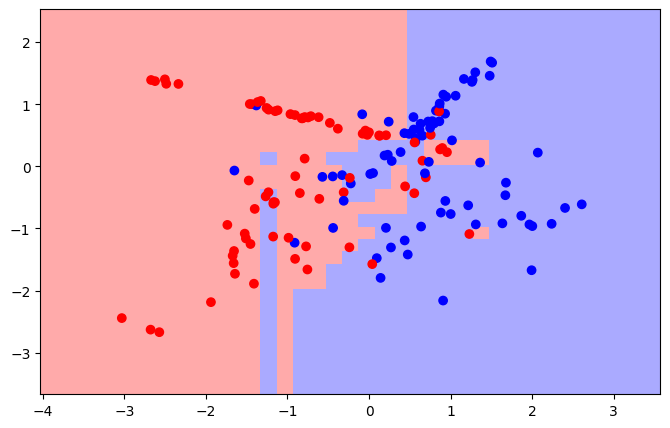

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300, verbosity=0)

xgb.fit(X_train, y_train)
plot_surface(X_test, y_test, xgb)

print(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

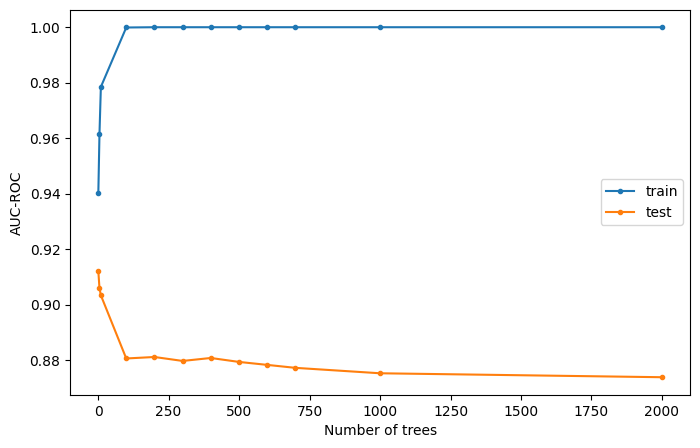

In [7]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000]
quals_train = []
quals_test = []
for n in n_trees:
    xgboost = XGBClassifier(n_estimators=n, verbosity=0)
    xgboost.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, xgboost.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, xgboost.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Видно, что переобучились - качество на тесте только падает.

## LightGBM

[LightGBM] [Info] Number of positive: 172, number of negative: 178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491429 -> initscore=-0.034289
[LightGBM] [Info] Start training from score -0.034289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

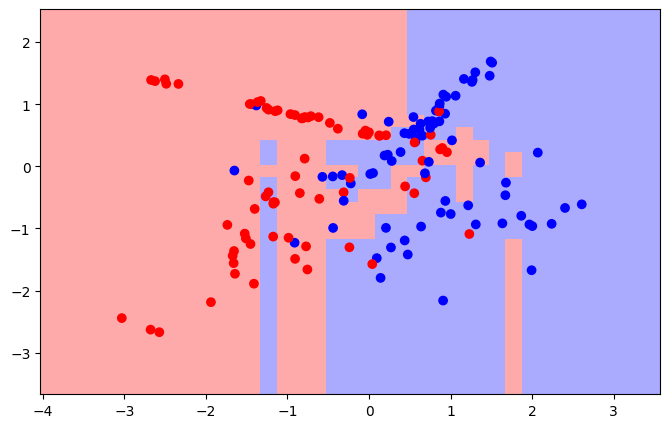

In [8]:
from lightgbm import LGBMClassifier

lightgbm = LGBMClassifier(n_estimators=300)
lightgbm.fit(X_train, y_train)
plot_surface(X_test, y_test, lightgbm)

print(roc_auc_score(y_test, lightgbm.predict_proba(X_test)[:, 1]))

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

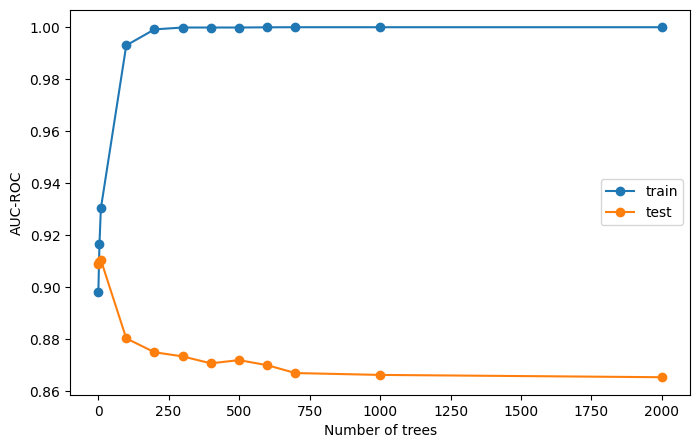

In [9]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000]
quals_train = []
quals_test = []
for n in n_trees:
    lightgbm = LGBMClassifier(n_estimators=n)
    lightgbm.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lightgbm.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lightgbm.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

В целом, у LightGBM получилась та же проблема с переобучением, как у Xgboost. Нужно дальше подбирать гиперпараметры для этих двух.

Попробуем взять фиксированное количество деревьев `n_estimators`, но будем менять их максимальную глубину `max_depth`. У этих алгоритмов разное время обучения, поэтому возьмем какой-то небольшой диапазон глубины и сравним все три модели - Catboost, LightGBM, Xgboost.

In [10]:
def plot_model_diff_depths(model=LGBMClassifier, depth_range=list(range(1, 5)), n_trees=10):
    roc_auc_train = []
    roc_auc_test = []
    for i in depth_range:
        clf = model(n_estimators=n_trees, max_depth=i)
        if type(clf) == type(CatBoostClassifier()):
            clf = CatBoostClassifier(n_estimators=n_trees, max_depth=i, logging_level="Silent")
        clf.fit(X_train, y_train)
        q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
        q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        roc_auc_train.append(q_train)
        roc_auc_test.append(q_test)

    plt.figure(figsize=(7, 5))
    plt.plot(depth_range, roc_auc_train, marker='o', label='train')
    plt.plot(depth_range, roc_auc_test, marker='o', label='test')
    plt.title(f'{model}')
    plt.xlabel('Depth')
    plt.ylabel('AUC-ROC')
    plt.legend()

    plt.show()

[LightGBM] [Info] Number of positive: 172, number of negative: 178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491429 -> initscore=-0.034289
[LightGBM] [Info] Start training from score -0.034289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

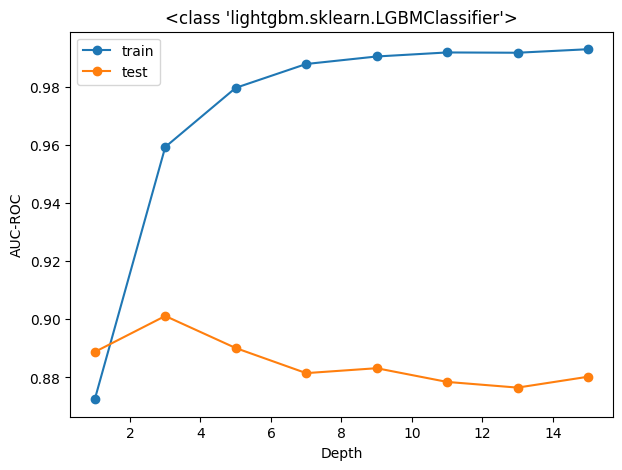

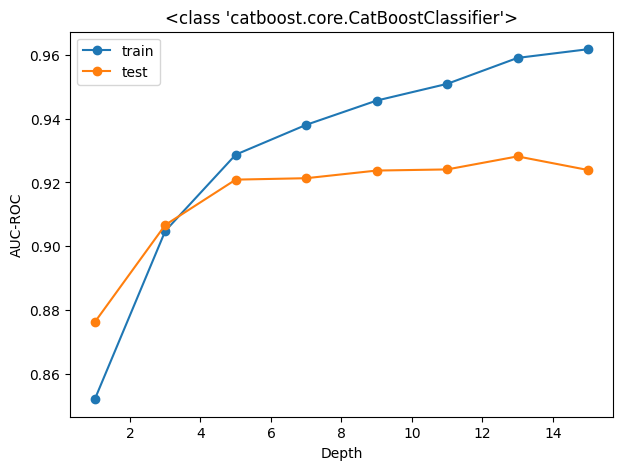

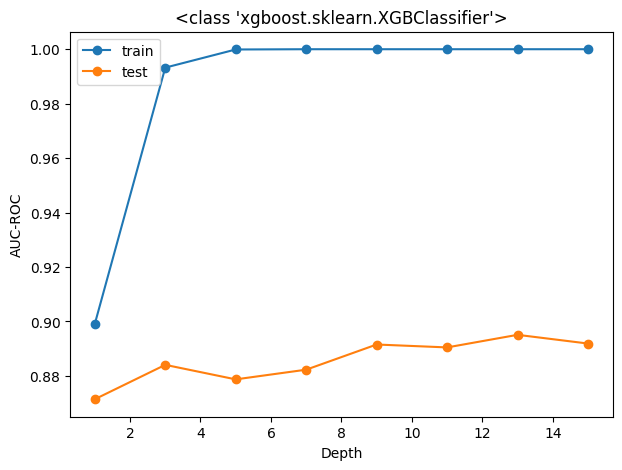

In [11]:
plot_model_diff_depths(model=LGBMClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)
plot_model_diff_depths(model=CatBoostClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)
plot_model_diff_depths(model=XGBClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)

Когда мы обучили лучшие версии моделей, можно их сохранить и использовать для получения предсказаний, например, на новом батче данных.

In [12]:
# Сохранить
lightgbm.booster_.save_model('lightgbm.txt')
catboost.save_model('catboost.cbm', format='cbm')
xgboost.save_model('xgboost.json')

# Загрузить
lightgbm = LGBMClassifier(model_file='mode.txt')
catboost = catboost.load_model('catboost.cbm')
xgboost = xgboost.load_model('xgboost.json')

## Catboost для решения задачи + интерпретация признаков

In [13]:
data = pd.read_csv("https://raw.githubusercontent.com/Murcha1990/ML_AI24/refs/heads/main/Lesson9_ClassificationBase/bike_buyers_clean.csv")

In [14]:
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes


In [15]:
X = data.drop(['ID','Purchased Bike'], axis=1)
y = data['Purchased Bike']

In [16]:
X.head()

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
0,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42
1,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43
2,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60
3,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41
4,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36


In [17]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=42)

In [18]:
from catboost import CatBoostClassifier

model1 = CatBoostClassifier(cat_features = [0, 1, 4, 5, 6, 8, 9])  # one_hot_max_size=10)
model1.fit(Xtrain, ytrain)

Learning rate set to 0.007663
0:	learn: 0.6914998	total: 4.3ms	remaining: 4.29s
1:	learn: 0.6896181	total: 7.07ms	remaining: 3.53s
2:	learn: 0.6886421	total: 9.55ms	remaining: 3.17s
3:	learn: 0.6876323	total: 11.7ms	remaining: 2.92s
4:	learn: 0.6864179	total: 14ms	remaining: 2.78s
5:	learn: 0.6844497	total: 16.1ms	remaining: 2.67s
6:	learn: 0.6836725	total: 18ms	remaining: 2.55s
7:	learn: 0.6832042	total: 19.1ms	remaining: 2.36s
8:	learn: 0.6821674	total: 21.5ms	remaining: 2.37s
9:	learn: 0.6809083	total: 23.7ms	remaining: 2.34s
10:	learn: 0.6797446	total: 26ms	remaining: 2.33s
11:	learn: 0.6779929	total: 28.4ms	remaining: 2.33s
12:	learn: 0.6770262	total: 30.5ms	remaining: 2.32s
13:	learn: 0.6760905	total: 32.1ms	remaining: 2.26s
14:	learn: 0.6756093	total: 34ms	remaining: 2.23s
15:	learn: 0.6748941	total: 36.1ms	remaining: 2.22s
16:	learn: 0.6731904	total: 38.4ms	remaining: 2.22s
17:	learn: 0.6721898	total: 40.5ms	remaining: 2.21s
18:	learn: 0.6716759	total: 41.9ms	remaining: 2.16s
1

In [20]:
from sklearn.metrics import accuracy_score

pred = model1.predict(Xtest)

accuracy_score(ytest, pred)

0.664

In [21]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : np.arange(10,20,3),
          'learning_rate' : [0.01, 0.05, 0.1],
          'one_hot_max_size' : [10, 50, 100]}

gs = GridSearchCV(CatBoostClassifier(n_estimators=100, cat_features = [0, 1, 4, 5, 6, 8, 9], verbose=0), params, cv=3, scoring='accuracy', verbose=2)

gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=10; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=10; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=10; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=50; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=13, one_hot_max_size=10; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=13, one_hot_max_size=10; total time=   0.6s
[CV] END learning_rate

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7948085aa780>,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': array([10, 13, 16, 19]),
                         'one_hot_max_size': [10, 50, 100]},
             scoring='accuracy', verbose=2)

In [23]:
gs.best_score_, gs.best_params_

(0.6980496837650002,
 {'learning_rate': 0.01, 'max_depth': 13, 'one_hot_max_size': 10})